### Bar plots

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from plot import plot_bar, plot_bar_scatter, plot_bar_scatter_hor
import glob
import pandas as pd

from pathlib import Path

def get_metric(files, metric_name, return_type=None):
    try:
        vals = [pd.read_csv(f)[metric_name].mean() for f in files]
    except:
        return np.nan
    if return_type=='mean':
        return np.mean(vals)
    if return_type=='std':
        return np.std(vals)
    else:
        return vals

def mean_sd(values):
    return np.mean(values)

model_key_to_name={
 'state-sets': 'State-Sets',
 'sets': 'Sets',
 'pert_mean': 'Pert Mean',
 'cell_mean': 'Cell Type Mean',
 'lrlm': 'Linear',
 'scvi': 'scVI',
 'cpa': 'CPA',
 'scgpt': 'scGPT'
}


In [30]:
files = glob.glob("/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_globalsimplesum_cs256_2000_hvg_globalsimplesum/parse_donor_globalsimplesum_2000/eval_final.ckpt/*_results.csv")
files = [f for f in files if 'agg' not in f]
get_metric(files, 'de_spearman_sig', 'mean')

0.11772768608316819

### Plots: Tahoe

In [31]:
files = {}

#files['state-sets'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_redo/tahoe_best_cs256_2000_state/tahoe_best_2000_state/eval_exp.ckpt/*_results.csv')
files['sets'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_results.csv')
files['pert_mean']  = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_globalsimplesum/holdout/eval_final.ckpt/*_results.csv')
files['cell_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_celltypemean/holdout/eval_final.ckpt/*_results.csv')

files['cpa'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/cpa_tahoe/tahoe_generalization/*_results.csv')
files['cpa'] += glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/cpa_tahoe/tahoe_generalization/HepG2/*_results.csv')

files['scvi'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scvi_tahoe/tahoe_generalization/*_results.csv')
files['scvi'] += glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scvi_tahoe/tahoe_generalization/HepG2/*_results.csv')

## One of these cell lines is missing
files['scgpt'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scgpt_tahoe/tahoe_generalization/*_results.csv')
files['scgpt'] += glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scgpt_tahoe/tahoe_generalization/HepG2/*_results.csv')

files['lrlm'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/*_results.csv')
files['lrlm'] += glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/HepG2/*_results.csv')



In [32]:
def filter_keep_single_celltype(file_list):
    return [
        f for f in file_list
        if (
            Path(f).name == 'C3A_results.csv' or
            not ((parts := Path(f).stem.replace('_results', '').split('_')) and len(parts) == 2 and parts[0] == parts[1])
        )
    ]

In [33]:
for k, files_ in files.items():
    files[k] = filter_keep_single_celltype(files[k])
    files[k] = [f for f in files[k] if 'agg' not in f]

In [34]:
files['lrlm']

['/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/PANC-1_results.csv',
 '/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/Hs 766T_results.csv',
 '/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/C32_results.csv',
 '/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/HOP62_results.csv',
 '/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_tahoe/tahoe_generalization/HepG2/C3A_results.csv']

In [35]:
get_metric(files['lrlm'], 'overlap_at_N')

[0.2157134120712337,
 0.16337964199868943,
 0.22054104886169368,
 0.2744092744576538,
 0.1396894563433795]

In [36]:
# ------------------------------------------------------------------
values_dict = {}
err_dict = {}
titles_dict = {}
outpaths_dict = {}
groups_dict = {}
cell_vals_dict = {}

keys        = ['sets', 'pert_mean', 'cell_mean', 'lrlm', 'scvi', 'cpa', 'scgpt']
model_names = [model_key_to_name[k] for k in keys]

# helper for NaN-safe transforms
def safe_apply(arr, fn):
    """Apply fn element-wise, converting NaNs to 0."""
    return [fn(x) if not np.isnan(x) else 0 for x in arr]

# ------------------------------------------------------------------
# one row per metric: (internal key, display title, output file, metric_name,
#                     val_transform, err_transform)
metrics = [
    ('Discrimination',   'Perturbation Discrimination', 'pert_discrim.svg',
     'discrimination_score_l1',
     lambda v: 1 - 2*v, lambda e: 2*e),

    ('Correlation',      'Pearson Correlation',         'pearson_corr.svg',
     'pearson_delta',
     lambda v: v,        lambda e: e),

    ('DE_Overlap',       'DE Genes Overlap (N)',        'de_overlap.svg',
     'overlap_at_N',
     lambda v: v,        lambda e: e),

    ('log fold change',  'Log fold change',             'logFC.svg',
     'de_spearman_lfc_sig',
     lambda v: v,        lambda e: e),

    ('Effect Sizes',     'Effect Sizes',                'effect_sizes.svg',
     'de_spearman_sig',
     lambda v: v,        lambda e: e),
]

# ------------------------------------------------------------------
# populate the dicts
for metric_title, disp_title, outpath, metric_name, v_tf, e_tf in metrics:
    titles_dict[metric_title]  = disp_title
    outpaths_dict[metric_title] = outpath
    groups_dict[metric_title]   = [disp_title]

    # raw means / stds
    raw_vals = [get_metric(files[k], metric_name, 'mean') for k in keys]
    raw_errs = [get_metric(files[k], metric_name, 'std')  for k in keys]
    raw_cell_vals = [get_metric(files[k], metric_name)  for k in keys]

    # transform & NaN-guard
    vals = safe_apply(raw_vals, v_tf)
    errs = safe_apply(raw_errs, e_tf)
    raw_cell_vals = [safe_apply(cv, v_tf) for cv in raw_cell_vals]
    

    # shape as (1, N) for downstream plotting code
    values_dict[metric_title] = np.expand_dims(vals, 1).T
    err_dict[metric_title]    = np.expand_dims(errs, 1).T
    cell_vals_dict[metric_title]    = raw_cell_vals


### Make Plots

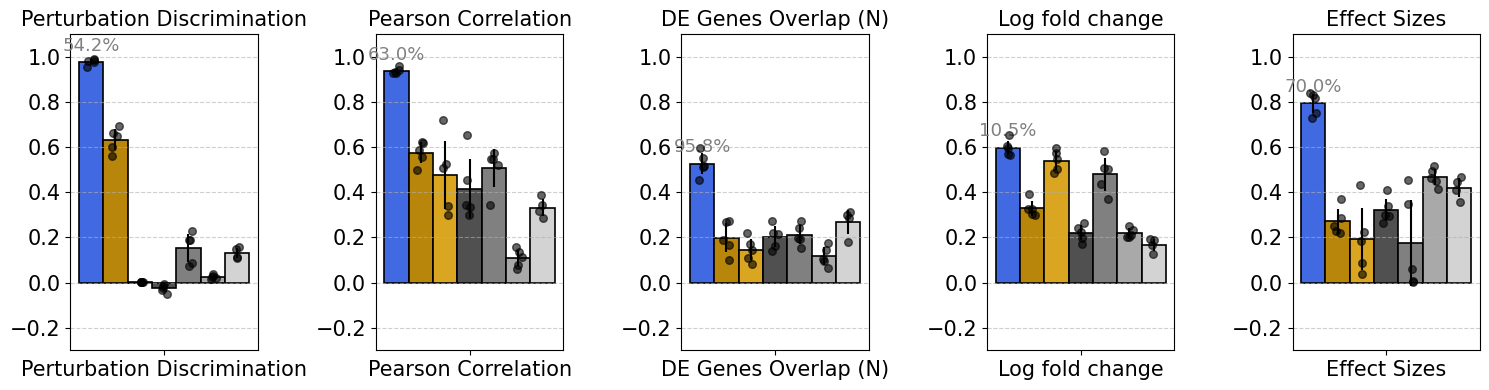

In [37]:
import matplotlib.pyplot as plt

metric_titles = list(values_dict.keys())
n = len(metric_titles)
fig, axes = plt.subplots(1, n, figsize=(3 * n, 4), squeeze=False)

for i, metric_title in enumerate(metric_titles):
    ax = axes[0, i]
    plot_bar_scatter_hor(
        values=values_dict[metric_title],
        groups=groups_dict[metric_title],
        raw_data=cell_vals_dict[metric_title],
        title=titles_dict[metric_title],
        errors=err_dict[metric_title],
        models=keys,
        ax=ax,
        legend=None,
        fontsize=15
    )

    # if this is the spearman‐metric plot, set the lower y‐limit to -0.3
    ##if metric_title == 'log fold change' or metric_title == 'Effect Sizes':
        # keep the auto‐computed upper bound (e.g. ~1.1) but drop the bottom
    upper = ax.get_ylim()[1]
    ax.set_ylim(-0.3, upper)

plt.tight_layout()
fig.savefig('all_metrics_tahoe.svg', dpi=300)
plt.show()


### Plots: Replogle

In [38]:
files = {}

files['state-sets'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_hvg_proper_cs32_sm/*/eval_step=144000.ckpt/*_results.csv')
files['sets'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_state_proper_cs32_sm/*/eval_step=48000.ckpt/*_results.csv')

files['pert_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_globalsimplesum/*/eval_final.ckpt/*_results.csv')
files['cell_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_filtered_celltypemean/*/eval_final.ckpt/*_results.csv')

files['cpa'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/cpa_replogle/fold*/*_results.csv')
files['scvi'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scvi_replogle/fold*/*_results.csv')
files['scgpt'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scgpt_replogle/fold*/*_results.csv')
files['lrlm'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_replogle/fold*/*_results.csv')


In [43]:
for k, files_ in files.items():
    files[k] = filter_keep_single_celltype(files[k])
    files[k] = [f for f in files[k] if 'agg' not in f]

In [44]:
## Remove this later
##files['cell_mean'] = [files['cell_mean'][0]] + [files['cell_mean'][1]] + [files['cell_mean'][3]]

In [45]:
# ------------------------------------------------------------------
values_dict = {}
err_dict = {}
titles_dict = {}
outpaths_dict = {}
groups_dict = {}
cell_vals_dict = {}


keys        = ['sets', 'pert_mean', 'cell_mean', 'lrlm', 'scvi', 'cpa', 'scgpt']
#keys        = ['state-sets', 'sets']
model_names = [model_key_to_name[k] for k in keys]

# helper for NaN-safe transforms
def safe_apply(arr, fn):
    """Apply fn element-wise, converting NaNs to 0."""
    try:
        if np.isnan(arr):
            #return []
            return [0] * len(files['sets'])
    except:
        return [fn(x) if not np.isnan(x) else 0 for x in arr]

# ------------------------------------------------------------------
# one row per metric: (internal key, display title, output file, metric_name,
#                     val_transform, err_transform)
metrics = [
    ('Discrimination',   'Perturbation Discrimination', 'pert_discrim.svg',
     'discrimination_score_l1',
     lambda v: 1 - 2*v, lambda e: 2*e),

    ('Correlation',      'Pearson Correlation',         'pearson_corr.svg',
     'pearson_delta',
     lambda v: v,        lambda e: e),

    ('auprc',  'auprc',             'auprc.svg',
     'pr_auc',
     lambda v: v,        lambda e: e),

    ('DE_Overlap',       'DE Genes Overlap (N)',        'de_overlap.svg',
     'overlap_at_N',
     lambda v: v,        lambda e: e),

    ('log fold change',  'Log fold change',             'logFC.svg',
     'de_spearman_lfc_sig',
     lambda v: v,        lambda e: e),

    ('Effect Sizes',     'Effect Sizes',                'effect_sizes.svg',
     'de_spearman_sig',
     lambda v: v,        lambda e: e),
]

# ------------------------------------------------------------------
# populate the dicts
# populate the dicts
for metric_title, disp_title, outpath, metric_name, v_tf, e_tf in metrics:
    titles_dict[metric_title]  = disp_title
    outpaths_dict[metric_title] = outpath
    groups_dict[metric_title]   = [disp_title]

    # raw means / stds
    raw_vals = [get_metric(files[k], metric_name, 'mean') for k in keys]
    raw_errs = [get_metric(files[k], metric_name, 'std')  for k in keys]
    raw_cell_vals = [get_metric(files[k], metric_name)  for k in keys]

    # transform & NaN-guard
    vals = safe_apply(raw_vals, v_tf)
    errs = safe_apply(raw_errs, e_tf)
    raw_cell_vals = [safe_apply(cv, v_tf) for cv in raw_cell_vals]
    

    # shape as (1, N) for downstream plotting code
    values_dict[metric_title] = np.expand_dims(vals, 1).T
    err_dict[metric_title]    = np.expand_dims(errs, 1).T
    cell_vals_dict[metric_title]    = raw_cell_vals


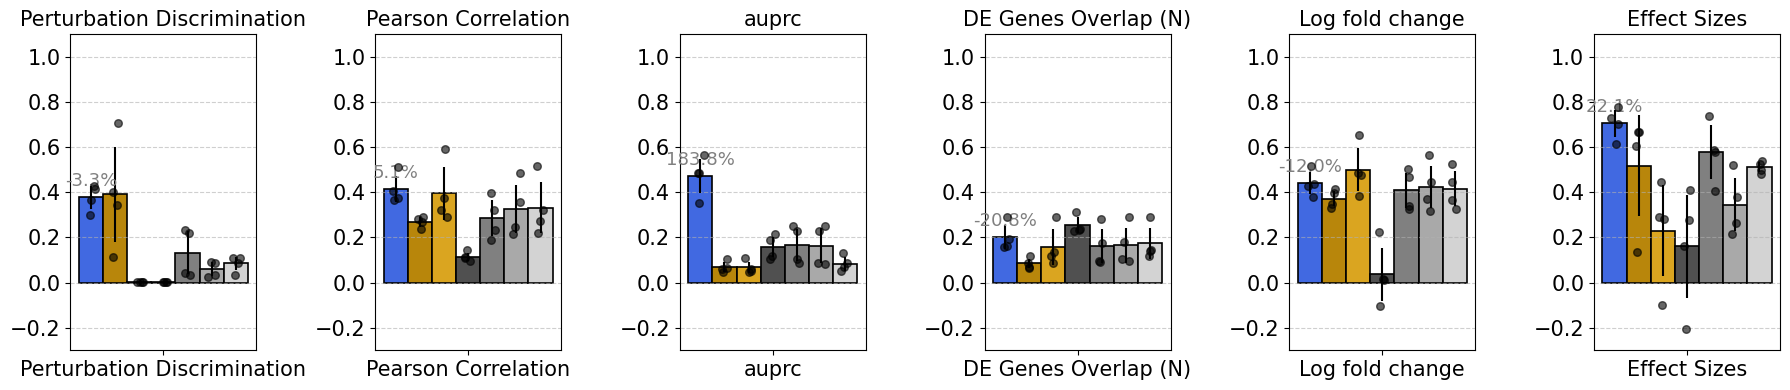

In [46]:
import matplotlib.pyplot as plt

metric_titles = list(values_dict.keys())
n = len(metric_titles)
fig, axes = plt.subplots(1, n, figsize=(3 * n, 4), squeeze=False)

for i, metric_title in enumerate(metric_titles):
    ax = axes[0, i]
    plot_bar_scatter_hor(
        values=values_dict[metric_title],
        groups=groups_dict[metric_title],
        raw_data=cell_vals_dict[metric_title],
        title=titles_dict[metric_title],
        errors=err_dict[metric_title],
        models=keys,
        ax=ax,
        legend=None,
        fontsize=15
    )

    # if this is the spearman‐metric plot, set the lower y‐limit to -0.3
    ##if metric_title == 'log fold change' or metric_title == 'Effect Sizes':
        # keep the auto‐computed upper bound (e.g. ~1.1) but drop the bottom
    upper = ax.get_ylim()[1]
    ax.set_ylim(-0.3, upper)

plt.tight_layout()
fig.savefig('all_metrics_replogle_3.svg', dpi=300)
plt.show()


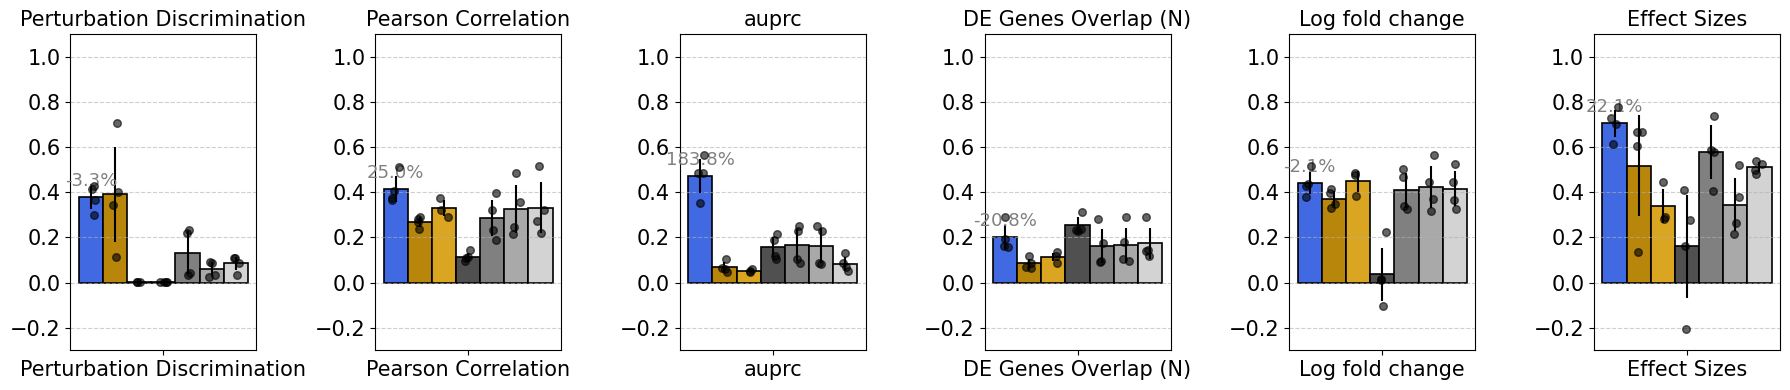

In [28]:
import matplotlib.pyplot as plt

metric_titles = list(values_dict.keys())
n = len(metric_titles)
fig, axes = plt.subplots(1, n, figsize=(3 * n, 4), squeeze=False)

for i, metric_title in enumerate(metric_titles):
    ax = axes[0, i]
    plot_bar_scatter_hor(
        values=values_dict[metric_title],
        groups=groups_dict[metric_title],
        raw_data=cell_vals_dict[metric_title],
        title=titles_dict[metric_title],
        errors=err_dict[metric_title],
        models=keys,
        ax=ax,
        legend=None,
        fontsize=15
    )

    # if this is the spearman‐metric plot, set the lower y‐limit to -0.3
    ##if metric_title == 'log fold change' or metric_title == 'Effect Sizes':
        # keep the auto‐computed upper bound (e.g. ~1.1) but drop the bottom
    upper = ax.get_ylim()[1]
    ax.set_ylim(-0.3, upper)

plt.tight_layout()
fig.savefig('all_metrics_replogle_3.svg', dpi=300)
plt.show()


### Plots: Cytokine (cell type)

In [52]:
files = {}

files['sets'] =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_celltype_tahoe_best_cs512_2000_hvg/parse_celltype_tahoe_best_2000/eval_step=100000.ckpt/*_results.csv')
files['pert_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_celltype_globalsimplesum_cs256_2000_hvg_globalsimplesum/parse_celltype_globalsimplesum_2000/eval_final.ckpt/*_results.csv')
files['cell_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_celltype_celltypemean_cs256_2000_hvg_celltypemean/parse_celltype_celltypemean_2000/eval_final.ckpt/*_results.csv')

files['cpa'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/cpa_pbmc/cell_type/*_results.csv')
files['scvi'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scvi_pbmc/cell_type/*_results.csv')
files['scgpt'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scgpt_pbmc/cell_type/*_results.csv')


In [49]:
for k, files_ in files.items():
    files[k] = [f for f in files_ if 'agg' not in f]

In [51]:
# ------------------------------------------------------------------
values_dict = {}
err_dict = {}
titles_dict = {}
outpaths_dict = {}
groups_dict = {}

keys        = ['sets', 'pert_mean', 'cell_mean', 'lrlm', 'scvi', 'cpa', 'scgpt']
model_names = [model_key_to_name[k] for k in keys]

# helper for NaN-safe transforms
def safe_apply(arr, fn):
    """Apply fn element-wise, converting NaNs to 0."""
    return [fn(x) if not np.isnan(x) else 0 for x in arr]

# ------------------------------------------------------------------
# one row per metric: (internal key, display title, output file, metric_name,
#                     val_transform, err_transform)
metrics = [
    ('Discrimination',   'Perturbation Discrimination', 'pert_discrim.svg',
     'discrimination_score_l1',
     lambda v: 1 - 2*v, lambda e: 2*e),

    ('Correlation',      'Pearson Correlation',         'pearson_corr.svg',
     'pearson_delta',
     lambda v: v,        lambda e: e),

    ('DE_Overlap',       'DE Genes Overlap (N)',        'de_overlap.svg',
     'overlap_at_N',
     lambda v: v,        lambda e: e),

    ('log fold change',  'Log fold change',             'logFC.svg',
     'de_spearman_lfc_sig',
     lambda v: v,        lambda e: e),

    ('Effect Sizes',     'Effect Sizes',                'effect_sizes.svg',
     'de_spearman_sig',
     lambda v: v,        lambda e: e),
]

# ------------------------------------------------------------------
# populate the dicts
for metric_title, disp_title, outpath, metric_name, v_tf, e_tf in metrics:
    titles_dict[metric_title]  = disp_title
    outpaths_dict[metric_title] = outpath
    groups_dict[metric_title]   = [disp_title]

    # raw means / stds
    raw_vals = [get_metric(files[k], metric_name, 'mean') for k in keys]
    raw_errs = [get_metric(files[k], metric_name, 'std')  for k in keys]

    # transform & NaN-guard
    vals = safe_apply(raw_vals, v_tf)
    errs = safe_apply(raw_errs, e_tf)

    # shape as (1, N) for downstream plotting code
    values_dict[metric_title] = np.expand_dims(vals, 1).T
    err_dict[metric_title]    = np.expand_dims(errs, 1).T


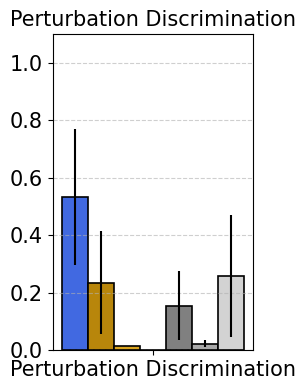

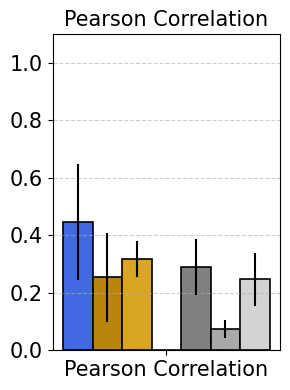

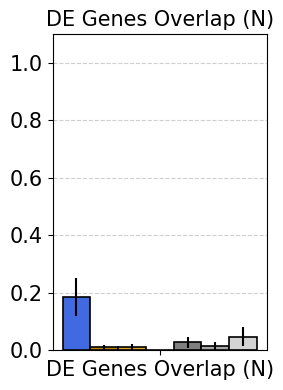

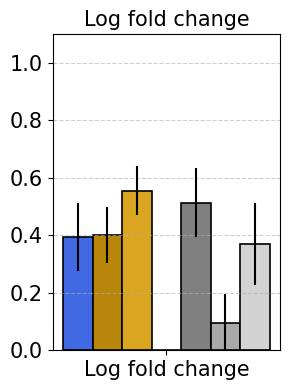

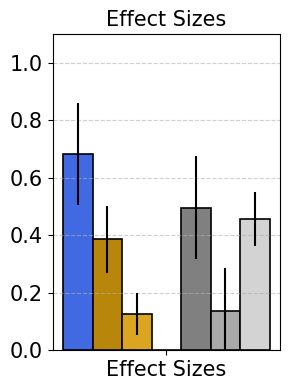

In [25]:
for metric_title in values_dict.keys():
    plot_bar(values_dict[metric_title], 
             groups_dict[metric_title], 
             title=titles_dict[metric_title], 
             errors=err_dict[metric_title],
             models=keys, save_path=outpaths_dict[metric_title],
             figsize=(3,4), fontsize=15)


### Plots: Cytokine (donor)

In [71]:
files = {}

files['state-sets'] = glob.glob("/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_tahoe_best_cs512_2000_state_pretrained/parse_donor_state_2000/eval_step=136000.ckpt/*_results.csv")
files['sets'] =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_tahoe_best_cs512_2000_hvg/parse_donor_tahoe_best_2000/eval_step=100000.ckpt/*_results.csv')
files['pert_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_globalsimplesum_cs256_2000_hvg_globalsimplesum/parse_donor_globalsimplesum_2000/eval_final.ckpt/*_results.csv')
files['cell_mean'] = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_celltypemean_cs256_2000_hvg_celltypemean/parse_donor_celltypemean_2000/eval_final.ckpt/*_results.csv')

files['cpa'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/cpa_pbmc/donor/*_results.csv')
files['scvi'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scvi_pbmc/donor/*_results.csv')
files['scgpt'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/scgpt_pbmc/donor/*_results.csv')
files['lrlm'] = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/state_sets_reproduce/lrlm_pbmc/donor/*_results.csv')


In [81]:
for k, files_ in files.items():
    files[k] = [f for f in files_ if 'agg' not in f]

In [82]:
# ------------------------------------------------------------------
values_dict = {}
err_dict = {}
titles_dict = {}
outpaths_dict = {}
groups_dict = {}

keys        = ['sets', 'pert_mean', 'cell_mean', 'lrlm', 'scvi', 'cpa', 'scgpt']
model_names = [model_key_to_name[k] for k in keys]

# helper for NaN-safe transforms
def safe_apply(arr, fn):
    """Apply fn element-wise, converting NaNs to 0."""
    return [fn(x) if not np.isnan(x) else 0 for x in arr]

# ------------------------------------------------------------------
# one row per metric: (internal key, display title, output file, metric_name,
#                     val_transform, err_transform)
metrics = [
    ('Discrimination',   'Perturbation Discrimination', 'pert_discrim.svg',
     'discrimination_score_l1',
     lambda v: 1 - 2*v, lambda e: 2*e),

    ('Correlation',      'Pearson Correlation',         'pearson_corr.svg',
     'pearson_delta',
     lambda v: v,        lambda e: e),

    ('DE_Overlap',       'DE Genes Overlap (N)',        'de_overlap.svg',
     'overlap_at_N',
     lambda v: v,        lambda e: e),

    ('log fold change',  'Log fold change',             'logFC.svg',
     'de_spearman_lfc_sig',
     lambda v: v,        lambda e: e),

    ('Effect Sizes',     'Effect Sizes',                'effect_sizes.svg',
     'de_spearman_sig',
     lambda v: v,        lambda e: e),
]

# ------------------------------------------------------------------
# populate the dicts
for metric_title, disp_title, outpath, metric_name, v_tf, e_tf in metrics:
    titles_dict[metric_title]  = disp_title
    outpaths_dict[metric_title] = outpath
    groups_dict[metric_title]   = [disp_title]

    # raw means / stds
    raw_vals = [get_metric(files[k], metric_name, 'mean') for k in keys]
    raw_errs = [get_metric(files[k], metric_name, 'std')  for k in keys]
    raw_cell_vals = [get_metric(files[k], metric_name)  for k in keys]

    # transform & NaN-guard
    vals = safe_apply(raw_vals, v_tf)
    errs = safe_apply(raw_errs, e_tf)
    raw_cell_vals = [safe_apply(cv, v_tf) for cv in raw_cell_vals]
    

    # shape as (1, N) for downstream plotting code
    values_dict[metric_title] = np.expand_dims(vals, 1).T
    err_dict[metric_title]    = np.expand_dims(errs, 1).T
    cell_vals_dict[metric_title]    = raw_cell_vals


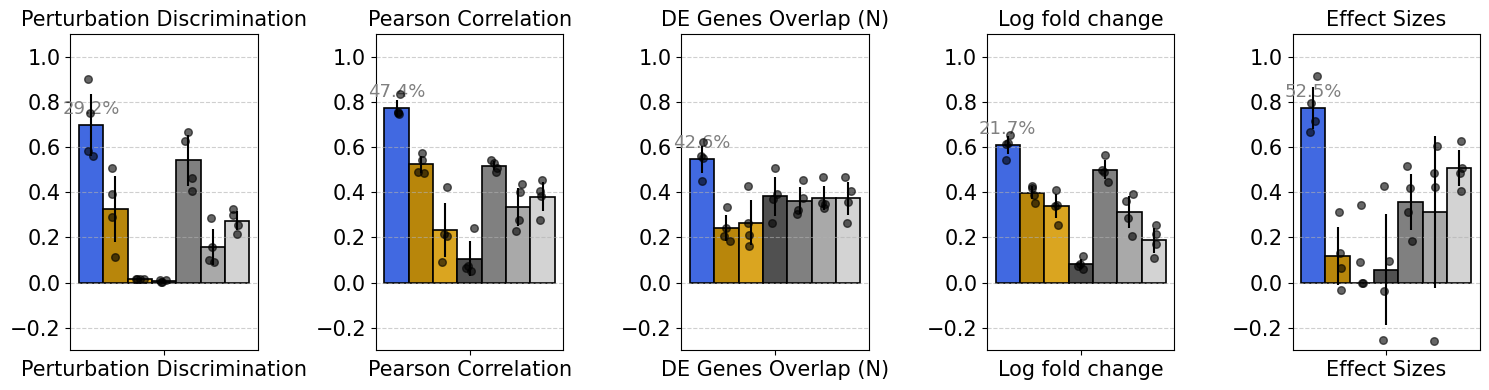

In [83]:
import matplotlib.pyplot as plt

metric_titles = list(values_dict.keys())
n = len(metric_titles)
fig, axes = plt.subplots(1, n, figsize=(3 * n, 4), squeeze=False)

for i, metric_title in enumerate(metric_titles):
    ax = axes[0, i]
    plot_bar_scatter_hor(
        values=values_dict[metric_title],
        groups=groups_dict[metric_title],
        raw_data=cell_vals_dict[metric_title],
        title=titles_dict[metric_title],
        errors=err_dict[metric_title],
        models=keys,
        ax=ax,
        legend=None,
        fontsize=15
    )

    # if this is the spearman‐metric plot, set the lower y‐limit to -0.3
    ##if metric_title == 'log fold change' or metric_title == 'Effect Sizes':
        # keep the auto‐computed upper bound (e.g. ~1.1) but drop the bottom
    upper = ax.get_ylim()[1]
    ax.set_ylim(-0.3, upper)

plt.tight_layout()
fig.savefig('all_metrics_cytokine.svg', dpi=300)
plt.show()


### Precision Recall curves

### Tahoe

In [136]:
import glob
import pandas as pd

#sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_downstream_de_results.csv')
sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_avg_pr_curve.csv')
sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

scgpt_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/scgpt_tahoe_final/scgpt_tahoe_fold*/*_avg_pr_curve.csv')
scgpt_cell_names = [x.split('/')[-1].split('_')[0] for x in scgpt_file_names]
scgpt_name_dict = {x:y for x,y in zip(scgpt_cell_names, scgpt_file_names)}

cpa_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/cpa_tahoe_final/fold*/*_avg_pr_curve.csv')
cpa_cell_names = [x.split('/')[-1].split('_')[0] for x in cpa_file_names]
cpa_name_dict = {x:y for x,y in zip(cpa_cell_names, cpa_file_names)}

scvi_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/scvi_tahoe_final/fold*/*_avg_pr_curve.csv')
scvi_cell_names = [x.split('/')[-1].split('_')[0] for x in scvi_file_names]
scvi_name_dict = {x:y for x,y in zip(scvi_cell_names, scvi_file_names)}



In [ ]:
ct_mean_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_hvg_gss/fold*/*_avg_pr_curve.csv')
ct_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in ct_mean_file_names]
ct_mean_name_dict = {x:y for x,y in zip(ct_mean_cell_names, ct_mean_file_names)}

pert_mean_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_llama_212693232_globalsimplesum/holdout/eval_final.ckpt/ fold*/*_avg_pr_curve.csv')
pert_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in pert_mean_file_names]
pert_mean_name_dict = {x:y for x,y in zip(pert_mean_cell_names, pert_mean_file_names)}

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
def plot_pr(df, ax=None, error=True, color='k', 
            label='Average Precision', linestyle='-', legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the main PR curve
    ax.plot(df['recall'], df['precision_mean'], label=label, color=color, linestyle=linestyle)

    # Plot the error shading
    if error:
        lower_bound = df['precision_mean'] - df['precision_std']
        upper_bound = df['precision_mean'] + df['precision_std']
        ax.fill_between(df['recall'], lower_bound, upper_bound, color=color, alpha=0.2)

    # Styling
    ax.set_xlabel('Recall', fontsize=15)
    ax.set_ylabel('Precision', fontsize=15)
    ax.set_title('Precision-Recall Curve', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    if legend:
        ax.legend()
    
    return ax


def get_mean_pr_for_model(names_dict):
    dfs = []
    for cell_name, file_name in names_dict.items():
        dfs.append(pd.read_csv(file_name))

    concat_df = pd.concat(dfs)
    all_concat = concat_df.groupby('recall').mean()
    all_concat =all_concat.reset_index()

    return all_concat

# Call the function with your DataFrame
# plot_pr_with_error(df)


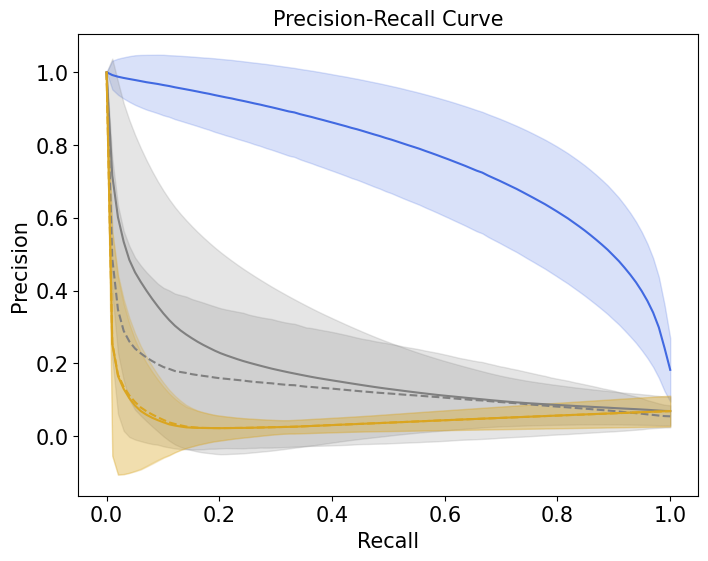

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_df = get_mean_pr_for_model(sts_name_dict)
ax = plot_pr(plot_df, error=True, color='royalblue', ax=ax, label='State-Set')

plot_df = get_mean_pr_for_model(cpa_name_dict)
ax = plot_pr(plot_df, error=True, color='gray', ax=ax, label='CPA')

plot_df = get_mean_pr_for_model(scvi_name_dict)
ax = plot_pr(plot_df, error=True, color='gray', ax=ax, linestyle='--', label='scVI')

plot_df = get_mean_pr_for_model(pert_mean_name_dict)
ax = plot_pr(plot_df, error=True, color='goldenrod', ax=ax, label='Pert Mean')

plot_df = get_mean_pr_for_model(ct_mean_name_dict)
ax = plot_pr(plot_df, error=True, color='goldenrod', ax=ax, linestyle='--', label='Context Mean')

"""
plt.legend(
    loc='center left', 
    bbox_to_anchor=(-1.35, 0.5), 
    ncol=1, 
    fontsize=15, 
    title='Models',
    title_fontsize=15
)
"""
#plt.tight_layout()
plt.savefig('PR_tahoe.png')

### Replogle

In [139]:
import glob
import pandas as pd

#sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_downstream_de_results.csv')
sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/mar5/replogle_sm_cs64_vci_1.4.2_ft2/fold*/*_avg_pr_curve.csv')
sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

ct_mean_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/mar5/replogle_hvg_gss/fold*/*_avg_pr_curve.csv')
ct_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in ct_mean_file_names]
ct_mean_name_dict = {x:y for x,y in zip(ct_mean_cell_names, ct_mean_file_names)}

pert_mean_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/mar5/replogle_hvg_ctm/fold*/*_avg_pr_curve.csv')
pert_mean_cell_names = [x.split('/')[-1].split('_')[0] for x in pert_mean_file_names]
pert_mean_name_dict = {x:y for x,y in zip(pert_mean_cell_names, pert_mean_file_names)}

scgpt_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/scgpt_replogle_final/fold*/*_avg_pr_curve.csv')
scgpt_cell_names = [x.split('/')[-1].split('_')[0] for x in scgpt_file_names]
scgpt_name_dict = {x:y for x,y in zip(scgpt_cell_names, scgpt_file_names)}

cpa_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/cpa_replogle_final/fold*/*_avg_pr_curve.csv')
cpa_cell_names = [x.split('/')[-1].split('_')[0] for x in cpa_file_names]
cpa_name_dict = {x:y for x,y in zip(cpa_cell_names, cpa_file_names)}

scvi_file_names = glob.glob('/large_storage/goodarzilab/userspace/mohsen/VCI-PertBench/scvi_replogle_final/fold*/*_avg_pr_curve.csv')
scvi_cell_names = [x.split('/')[-1].split('_')[0] for x in scvi_file_names]
scvi_name_dict = {x:y for x,y in zip(scvi_cell_names, scvi_file_names)}

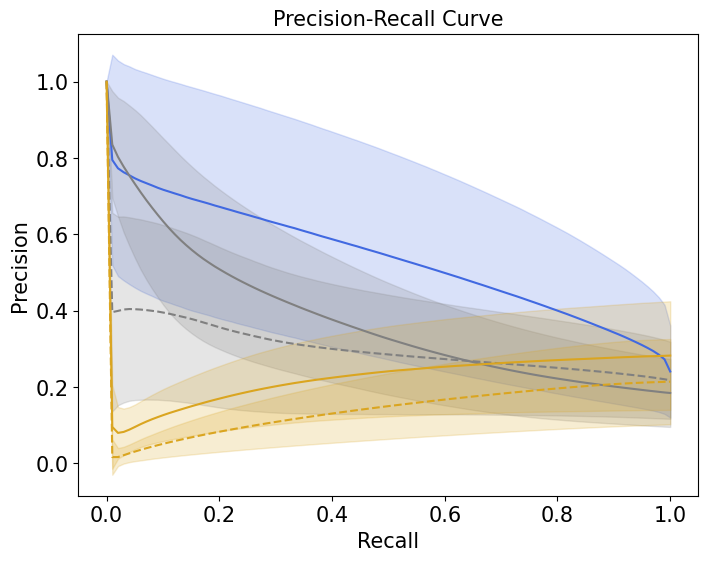

In [141]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_df = get_mean_pr_for_model(sts_name_dict)
ax = plot_pr(plot_df, error=True, color='royalblue', ax=ax, label='State-Set')

plot_df = get_mean_pr_for_model(cpa_name_dict)
ax = plot_pr(plot_df, error=True, color='gray', ax=ax, label='CPA')

plot_df = get_mean_pr_for_model(scvi_name_dict)
ax = plot_pr(plot_df, error=True, color='gray', ax=ax, linestyle='--', label='scVI')

plot_df = get_mean_pr_for_model(pert_mean_name_dict)
ax = plot_pr(plot_df, error=True, color='goldenrod', ax=ax, label='Pert Mean')

plot_df = get_mean_pr_for_model(ct_mean_name_dict)
ax = plot_pr(plot_df, error=True, color='goldenrod', ax=ax, linestyle='--', label='Context Mean')

"""
plt.legend(
    loc='center left', 
    bbox_to_anchor=(-1.35, 0.5), 
    ncol=1, 
    fontsize=15, 
    title='Models',
    title_fontsize=15
)
"""
#plt.tight_layout()
plt.savefig('PR_replogle.png')

#### Heatmaps plot

### Replogle

In [104]:
import glob
import pandas as pd
from tqdm import tqdm

#sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_downstream_de_results.csv')
sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_state_proper_cs32_sm/*/eval_step=48000.ckpt/*_pred_de*.csv')
sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

true_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/replogle_state_proper_cs32_sm/*/eval_step=48000.ckpt/*_real_de*.csv')
true_cell_names = [x.split('/')[-1].split('_')[0] for x in true_file_names]
true_name_dict = {x:y for x,y in zip(true_cell_names, true_file_names)}

In [105]:
def get_effect_size_from_de(df, target='target_gene'):
    effect_sizes = (df['fdr'] < 0.05).groupby(df['target']).sum().to_dict()
    ret_df = pd.DataFrame.from_dict(effect_sizes, orient='index').reset_index()
    ret_df = ret_df.rename(columns={'index':target, 0: 'significant_genes_count'})
    return ret_df

def get_sig_genes(fname, target='target_gene'):
    df = pd.read_csv(fname)
    return df.loc[:, [target, 'significant_genes_count']]

In [106]:
### Compute the predicted and true effect size for each perturbation

merged_effect_sizes = []

for fname in sts_file_names:
    cell_name = fname.split('/')[-1].split('_')[0]
    
    pred_fname = sts_name_dict[cell_name]
    pred_df = pd.read_csv(pred_fname)
    all_sig_genes_sts = get_effect_size_from_de(pred_df)

    true_fname = true_name_dict[cell_name]
    true_df = pd.read_csv(true_fname)
    all_sig_genes_true = get_effect_size_from_de(true_df)

    merged_effect_sizes.append(all_sig_genes_sts.merge(all_sig_genes_true, on='target_gene', suffixes=['_pred', '_true']))

In [107]:
merged_effect_sizes = pd.concat(merged_effect_sizes)

In [108]:
predicted_values = merged_effect_sizes['significant_genes_count_pred']
true_values = merged_effect_sizes['significant_genes_count_true']

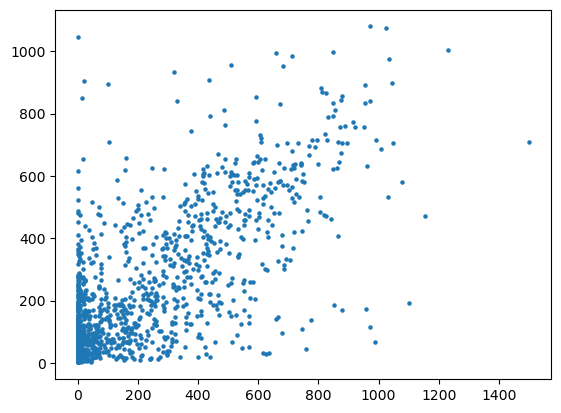

In [87]:
plt.scatter(predicted_values, true_values, s=5)

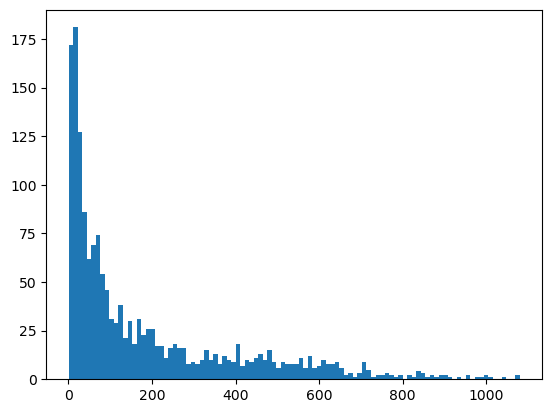

In [90]:
_ = plt.hist(true_values, bins=100)

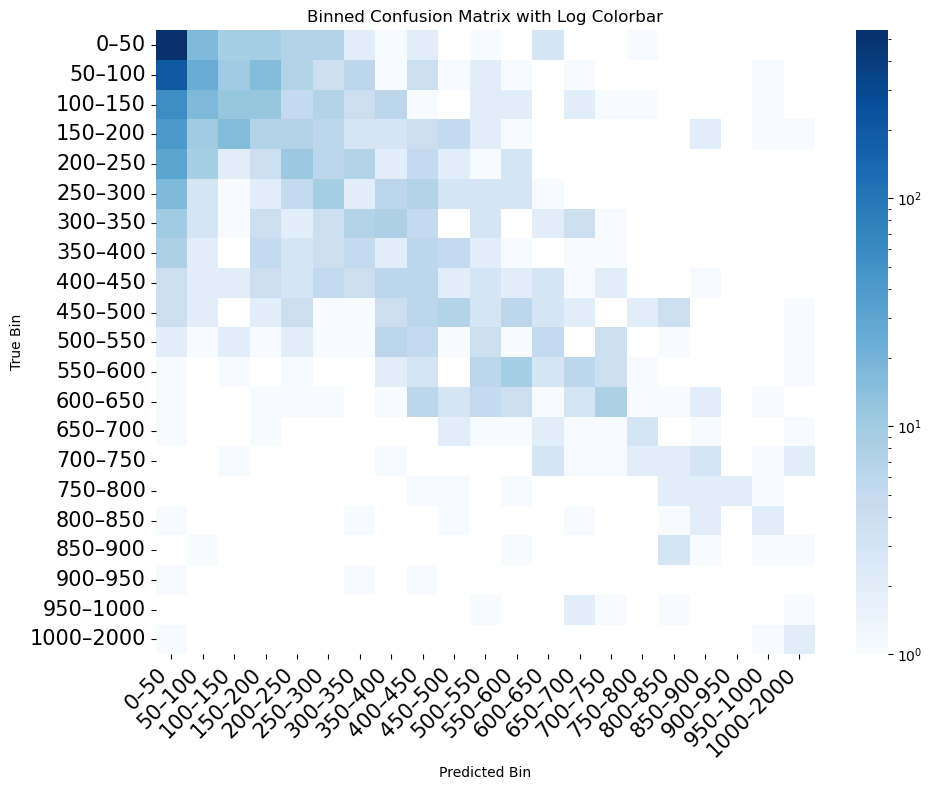

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# Assuming true_values and predicted_values are already defined

# Define bin edges
##bin_edges = [0, 5, 10, 15, 20, 50, 100, 200, 300, 400, 500, 600, 1000]

bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 2000]

num_bins = len(bin_edges) - 1

# Digitize the values into bins (excluding the first edge for digitize call)
true_bins = np.digitize(true_values, bins=bin_edges[1:], right=True)
predicted_bins = np.digitize(predicted_values, bins=bin_edges[1:], right=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_bins, predicted_bins, labels=range(num_bins))

# Format bin labels based on edges
bin_labels = [f'{bin_edges[i]}–{bin_edges[i+1]}' for i in range(num_bins)]

# Visualization with log color normalization
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
                 norm=LogNorm(vmin=max(conf_matrix.min(), 1), vmax=conf_matrix.max()),  # Avoid vmin=0 for LogNorm
                 xticklabels=bin_labels,
                 yticklabels=bin_labels)

plt.xlabel('Predicted Bin')
plt.ylabel('True Bin')
plt.title('Binned Confusion Matrix with Log Colorbar')
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.savefig('replogle_heatmap_log.svg')
plt.show()


### Tahoe

In [130]:
import glob
import pandas as pd
from tqdm import tqdm

#sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_downstream_de_results.csv')
sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_pred_de*.csv')
##sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_pred_de_results_*.csv')

sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

true_file_names =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_real_de*.csv')
##true_file_names =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_pred_de_results_*.csv')
true_cell_names = [x.split('/')[-1].split('_')[0] for x in true_file_names]
true_name_dict = {x:y for x,y in zip(true_cell_names, true_file_names)}

In [131]:
true_file_names

['/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C32_real_de.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/Hs 766T_real_de.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/HOP62_real_de.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/PANC-1_real_de.csv',
 '/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/C3A_real_de.csv']

In [132]:
### Compute the predicted and true effect size for each perturbation

merged_effect_sizes = []

for fname in sts_file_names:
    cell_name = fname.split('/')[-1].split('_')[0]
    
    pred_fname = sts_name_dict[cell_name]
    pred_df = pd.read_csv(pred_fname)
    all_sig_genes_sts = get_effect_size_from_de(pred_df, target='target')

    true_fname = true_name_dict[cell_name]
    true_df = pd.read_csv(true_fname)
    all_sig_genes_true = get_effect_size_from_de(true_df, target='target')

    merged_effect_sizes.append(all_sig_genes_sts.merge(all_sig_genes_true, on='target', suffixes=['_pred', '_true']))

In [133]:
merged_effect_sizes = pd.concat(merged_effect_sizes)

In [134]:
predicted_values = merged_effect_sizes['significant_genes_count_pred']
true_values = merged_effect_sizes['significant_genes_count_true']

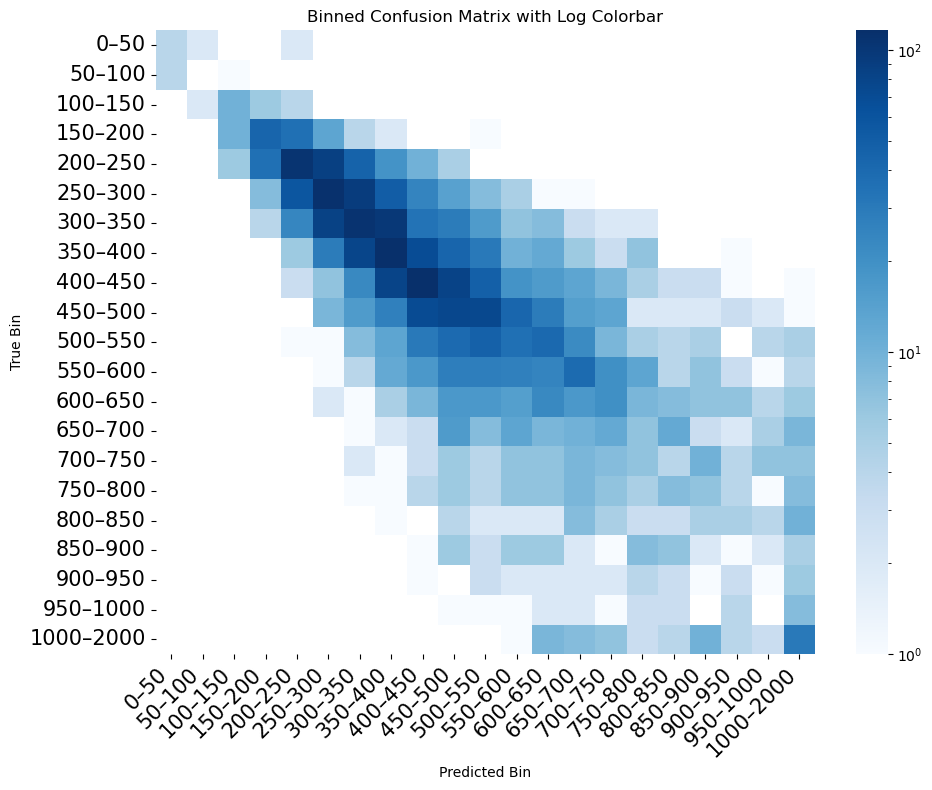

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# Define bin edges
#bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 700, 800, 900, 1000, 2000]
bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 2000]
num_bins = len(bin_edges) - 1

# Digitize the values into bins (excluding the first edge for digitize call)
true_bins = np.digitize(true_values, bins=bin_edges[1:], right=True)
predicted_bins = np.digitize(predicted_values, bins=bin_edges[1:], right=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_bins, predicted_bins, labels=range(num_bins))

# Format bin labels based on edges
bin_labels = [f'{bin_edges[i]}–{bin_edges[i+1]}' for i in range(num_bins)]

# Visualization with log-scaled colorbar
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    norm=LogNorm(vmin=max(conf_matrix.min(), 1), vmax=conf_matrix.max()),
    xticklabels=bin_labels,
    yticklabels=bin_labels
)

plt.xlabel('Predicted Bin')
plt.ylabel('True Bin')
plt.title('Binned Confusion Matrix with Log Colorbar')
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.savefig('tahoe_heatmap_log.svg')
plt.show()


### Cytokine

In [155]:
import glob
import pandas as pd
from tqdm import tqdm

sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_tahoe_best_cs512_2000_hvg/parse_donor_tahoe_best_2000/eval_step=100000.ckpt/*_pred_de*.csv')
sts_file_names = [f for f in sts_file_names if 'agg' not in f]

#sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_downstream_de_results.csv')
##sts_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/feb28_conc/cv_norm_vci_1.4.2_samp_ctrl_70m_512/fold*/*_pred_de_results_*.csv')

sts_cell_names = [x.split('/')[-1].split('_')[0] for x in sts_file_names]
sts_name_dict = {x:y for x,y in zip(sts_cell_names, sts_file_names)}

true_file_names = glob.glob('/large_storage/ctc/userspace/aadduri/preprint_parse/parse_donor_tahoe_best_cs512_2000_hvg/parse_donor_tahoe_best_2000/eval_step=100000.ckpt/*_real_de*.csv')
true_file_names = [f for f in true_file_names if 'agg' not in f]

##true_file_names =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_real_de*.csv')
##true_file_names =  glob.glob('/large_storage/ctc/userspace/aadduri/preprint/tahoe_scaling_cs256/cs256/eval_last.ckpt/*_pred_de_results_*.csv')
true_cell_names = [x.split('/')[-1].split('_')[0] for x in true_file_names]
true_name_dict = {x:y for x,y in zip(true_cell_names, true_file_names)}

In [156]:
### Compute the predicted and true effect size for each perturbation

merged_effect_sizes = []

for fname in sts_file_names:
    cell_name = fname.split('/')[-1].split('_')[0]
    
    pred_fname = sts_name_dict[cell_name]
    pred_df = pd.read_csv(pred_fname)
    all_sig_genes_sts = get_effect_size_from_de(pred_df)

    true_fname = true_name_dict[cell_name]
    true_df = pd.read_csv(true_fname)
    all_sig_genes_true = get_effect_size_from_de(true_df)

    merged_effect_sizes.append(all_sig_genes_sts.merge(all_sig_genes_true, on='target_gene', suffixes=['_pred', '_true']))

In [157]:
merged_effect_sizes = pd.concat(merged_effect_sizes)

In [158]:
predicted_values = merged_effect_sizes['significant_genes_count_pred']
true_values = merged_effect_sizes['significant_genes_count_true']

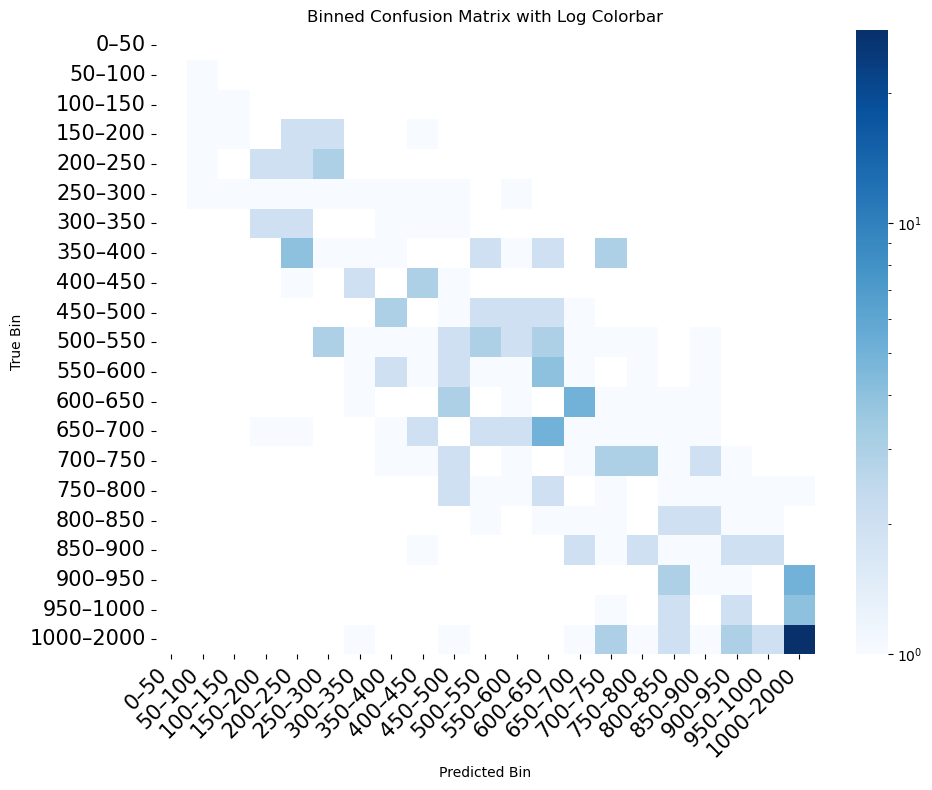

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# Define bin edges
#bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 700, 800, 900, 1000, 2000]
bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 2000]
num_bins = len(bin_edges) - 1

# Digitize the values into bins (excluding the first edge for digitize call)
true_bins = np.digitize(true_values, bins=bin_edges[1:], right=True)
predicted_bins = np.digitize(predicted_values, bins=bin_edges[1:], right=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_bins, predicted_bins, labels=range(num_bins))

# Format bin labels based on edges
bin_labels = [f'{bin_edges[i]}–{bin_edges[i+1]}' for i in range(num_bins)]

# Visualization with log-scaled colorbar
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    norm=LogNorm(vmin=max(conf_matrix.min(), 1), vmax=conf_matrix.max()),
    xticklabels=bin_labels,
    yticklabels=bin_labels
)

plt.xlabel('Predicted Bin')
plt.ylabel('True Bin')
plt.title('Binned Confusion Matrix with Log Colorbar')
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.savefig('parse_heatmap_log.svg')
plt.show()
